# Nueral Networks in Python/Numpy/Cupy

I had a few goals for this project.  The main goal was to gain better intuition for neural networks by building one only using python and numpy.  A secondary goal was to gain better understanding of Object Oriented Programming by building a NN OOP style.  Lastly, I wanted to explore GPU acceleration by using Cupy (essentially a gpu accelearted version of Numpy).

### Imports

In [1]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage

### Helper function to load data

In [2]:
def load_dataset():
    train_dataset = h5py.File('train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) #train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) #train set labels

    test_dataset = h5py.File('test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) #test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) #test set labels

    classes = np.array(test_dataset["list_classes"][:]) #list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [3]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_dataset()

### Data
Let's take a look and see what kind of images we will be using...

y = 1. It's a cat picture.


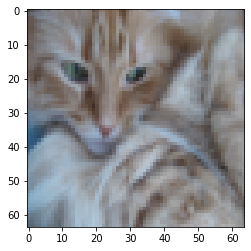

In [4]:
# Example of a picture
index = 2
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

Cat pictures of course! The dataset consits of cat and non-cat.

In [5]:
#Some simple exploration
n_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
n_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(n_train))
print ("Number of testing examples: " + str(n_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


In [6]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.
input_features = train_x.shape[0]


print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))
print(train_x[1][0])

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)
0.12156862745098039


### Building blocks of a neural network

In [7]:
np.random.seed(1)
class Layers_Dense:
    def __init__(self, x_features, n_neurons,num_examples,init='xavier',learning_rate=0.001):
        self.learning_rate=learning_rate
        self.m = num_examples
        if init == 'random':
            self.weights = np.random.randn(x_features,n_neurons) * 0.010         
        elif init == 'he':
            self.weights = np.random.randn(x_features,n_neurons)*np.sqrt(2./x_features)
        elif init == 'xavier':
            self.weights = np.random.randn(x_features,n_neurons)*np.sqrt(1./x_features)
        self.biases = np.zeros((n_neurons,1))
    def forward(self,x):
        self.output = np.dot(self.weights.T,x) + self.biases
        self.A_prev = x
    def backward(self,dZ):
        self.dW = (1/self.m)*(np.dot(dZ,self.A_prev.T))
        self.db = np.sum(dZ,axis=1,keepdims=True)/self.m
        self.dA = np.dot(self.weights,dZ)
        self.weights = self.weights + self.dW.T *-self.learning_rate
        self.biases = self.biases + self.db *-self.learning_rate

        
class ReLU:
    def forward(self, x):
        self.output = np.maximum(0,x)
        self.x = x
    def backward(self,dA):
        dZ = np.array(dA, copy=True)
        dZ[self.x <= 0] = 0
        self.dZ = dZ
        assert (dZ.shape == self.x.shape)
               
class Sigmoid:
    def forward(self, z):
        self.output = 1/(1+np.exp(-z))
    def backward(self):
        derivative = self.output * (1 - self.output)
        self.dZ = (self.dA_last * derivative)

    #sigmoid cross entropy
    def compute_cost(self,Y):
        m = Y.shape[1]
        self.cost = (-1/m)*(np.sum(Y*np.log(self.output)+(1-Y)*np.log(1-self.output)))
        self.dA_last = - (np.divide(Y, self.output) - np.divide(1 - Y, 1 - self.output))
        
class Softmax:
    def forward(self,x):
        x_exp = np.exp(x)
        x_sum = np.sum(x_exp, axis=1, keepdims=True)
        self.output = x_exp/x_sum
    def derivative(self):
        s = self.output.reshape(-1,1)
        self.ds = np.diagflats(s) - np.dot(s,s.T)

        
class Normalize:
    def normalize_rows(self,x):
        x_norm = np.linalg.norm(x,axis=1,ord=2,keepdims=True)
        self.output = x/x_norm
    def normalize_columns(self,x):
        x_norm = np.linalg.norm(x,axis=0,ord=2,keepdims=True)
        self.output = x/x_norm

#Still testing
class Leaky_ReLU:
    def __init__(self,alpha):
        self.leaky_slope = alpha
    def forward(self,x):
        self.x = x
        self.output = np.maximum(self.leaky_slope*x,x)
    def derivative(self):
        d = np.zeros_like(self.x)
        d[self.x<=0]=self.leaky_slope
        d[self.x>0]=1
        self.dl = d
        
class Tanh:
    def forward(self, x):
        self.output = np.tanh(x)
    def derivative(self):
        self.dt = (1-(np.square(self.output)))
                
class L1_Loss:
    def loss(self,predictions,Y):
        self.loss = np.sum(np.abs(Y - predictions))
        
class L2_Loss:
    def loss(self,predictions,Y):
        self.loss = np.sum(np.dot(Y-predictions,Y-predictions))

class Flatten:
    """Reshapes (l,h,d) image into (l*h*d,1)""" #might need work.  Currently dims first.
    def forward(self,x):
        self.output = x.reshape(x.shape[0]*x.shape[1]*x.shape[2],1)

### Let's build a model!
We will use 4 dense layers, relu activation functions (in the hidden layers), and sigmoid to output our 1 or 0 predictions. 

In [8]:
#Instantiate Model
layer1 = Layers_Dense(12288,20,n_train,init='he',learning_rate = 0.0075)
activation1 = ReLU()
layer2 = Layers_Dense(20,7,n_train,init='he',learning_rate = 0.0075)
activation2 = ReLU()
layer3 = Layers_Dense(7,5,n_train,init='he',learning_rate = 0.0075)
activation3 = ReLU()
layer4 = Layers_Dense(5,1,n_train,init='xavier',learning_rate = 0.0075)
sigmoid = Sigmoid()

### Helper function for predictions

In [9]:
def predict(x_test):
    m = x_test.shape[1]
    Y_prediction = np.zeros((1,m))
    
    layer1.forward(x_test)
    activation1.forward(layer1.output)
    layer2.forward(activation1.output)
    activation2.forward(layer2.output)
    layer3.forward(activation2.output)
    activation3.forward(layer3.output)
    layer4.forward(activation3.output)
    sigmoid.forward(layer4.output)
    predictions = sigmoid.output
    
    for i in range(predictions.shape[1]):
        if predictions[0][i] <= 0.5:
            Y_prediction[0][i] = 0
            #print('less than')
            #print(A[0][i])
        elif predictions[0][i] > 0.5:
            Y_prediction[0][i] = 1
    
    return Y_prediction

### Finally we can train!
Basic process is to calculate forward propagation for each layer, pass the outputs as the inputs to the next layer, compute the cost, and calculate all the derivatives going backward and doing gradient descent on the way.  Simple.

Iteration 0 cost: 0.718410 | Accuracy: 63.15789473684211 %
Iteration 100 cost: 0.508798 | Accuracy: 78.94736842105263 %
Iteration 200 cost: 0.353691 | Accuracy: 85.16746411483254 %
Iteration 300 cost: 0.285171 | Accuracy: 88.99521531100478 %
Iteration 400 cost: 0.140277 | Accuracy: 98.56459330143541 %
Iteration 500 cost: 0.088270 | Accuracy: 100.0 %
Iteration 600 cost: 0.046748 | Accuracy: 100.0 %
Iteration 700 cost: 0.032477 | Accuracy: 100.0 %
Iteration 800 cost: 0.023576 | Accuracy: 100.0 %
Iteration 900 cost: 0.018230 | Accuracy: 100.0 %
Iteration 1000 cost: 0.014633 | Accuracy: 100.0 %
Iteration 1100 cost: 0.012073 | Accuracy: 100.0 %
Iteration 1200 cost: 0.010170 | Accuracy: 100.0 %
Iteration 1300 cost: 0.008719 | Accuracy: 100.0 %
Iteration 1400 cost: 0.007572 | Accuracy: 100.0 %
Iteration 1500 cost: 0.006647 | Accuracy: 100.0 %
Iteration 1600 cost: 0.005905 | Accuracy: 100.0 %
Iteration 1700 cost: 0.005297 | Accuracy: 100.0 %
Iteration 1800 cost: 0.004789 | Accuracy: 100.0 %
It

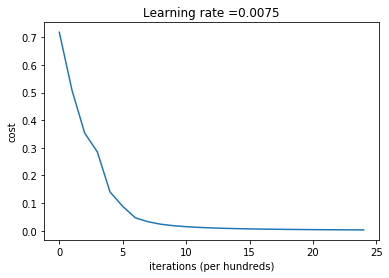

test accuracy: 74.0 %


In [10]:
np.random.seed(1)
costs = []
tic = time.perf_counter()
for i in range(2500):
    layer1.forward(train_x)
    activation1.forward(layer1.output)
    layer2.forward(activation1.output)
    activation2.forward(layer2.output)
    layer3.forward(activation2.output)
    activation3.forward(layer3.output)
    layer4.forward(activation3.output)
    sigmoid.forward(layer4.output)
    sigmoid.compute_cost(train_y)
    sigmoid.backward()
    layer4.backward(sigmoid.dZ)
    activation3.backward(layer4.dA)
    layer3.backward(activation3.dZ)
    activation2.backward(layer3.dA)
    layer2.backward(activation2.dZ)
    activation1.backward(layer2.dA)
    layer1.backward(activation1.dZ)
    

    if i % 100 == 0:
        costs.append(sigmoid.cost)
        predictions = predict(train_x)
        print('Iteration %d cost: %f' %(i, sigmoid.cost),"|",
             'Accuracy: {} %'.format(100 - np.mean(np.abs(predictions - train_y)) * 100))
        
toc = time.perf_counter()

print(f"Training time: {toc - tic:0.4f} seconds")
plt.plot(np.squeeze(costs))
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(layer1.learning_rate))
plt.show()

predictions = predict(test_x)
print("test accuracy: {} %".format(100 - np.mean(np.abs(predictions - test_y)) * 100))

## Now for the GPU accelerated version using CUPY!

In [11]:
import cupy as cp

In [12]:
train_x = cp.array(train_x)
test_x = cp.array(test_x)
test_y = cp.array(test_y)
train_y = cp.array(train_y)

In [13]:
class Layers_Dense():
    def __init__(self, x_features, n_neurons,num_examples,init='xavier',learning_rate=0.001):
        cp.random.seed(1)
        self.lr = learning_rate
        self.m = num_examples
        if init == 'random':
            self.W = cp.random.randn(x_features,n_neurons) * 0.01         
        elif init == 'he':
            self.W = cp.random.randn(x_features,n_neurons)*cp.sqrt(2./x_features)
        elif init == 'xavier':
            self.W = cp.random.randn(x_features,n_neurons)*cp.sqrt(1./x_features)
        self.b = cp.zeros((n_neurons, 1))
    def forward(self,x):
        self.output = cp.dot(self.W.T, x) + self.b
        self.A_prev = x #problem here need the activation
    def backward(self,dZ):
        self.dW = (1 / self.m)*(cp.dot(dZ, self.A_prev.T))
        self.db = cp.sum(dZ, axis=1 ,keepdims=True) / self.m
        self.dA = cp.dot(self.W, dZ)
        self.W = self.W + self.dW.T * -self.lr
        self.b = self.b + self.db * -self.lr

        
class ReLU:
    def forward(self, x):
        self.output = cp.maximum(0,x)
        self.x = x
    def backward(self,dA):
        dZ = cp.array(dA, copy=True)
        dZ[self.x <= 0] = 0
        self.dZ = dZ
        assert (dZ.shape == self.x.shape)

class Sigmoid:
    def forward(self, z):
        self.output = 1/(1+cp.exp(-z))
    def backward(self,Y):
        #derivative = self.output * (1 - self.output)
        #self.dZ = (self.dA_last * derivative)
        self.dZ = self.output - Y

    #sigmoid cross entropy
    def compute_cost(self,Y):
        m = Y.shape[1]
        self.cost = (-1/m)*(cp.sum(Y*cp.log(self.output)+(1-Y)*cp.log(1-self.output)))
        #self.dA_last = - (cp.divide(Y, self.output) - cp.divide(1 - Y, 1 - self.output))


In [15]:
#Instantiate Model
learning_rate = 0.0065
layer1 = Layers_Dense(12288,20,n_train,init='he',learning_rate = learning_rate)
activation1 = ReLU()
layer2 = Layers_Dense(20,7,n_train,init='he',learning_rate = learning_rate)
activation2 = ReLU()
layer3 = Layers_Dense(7,5,n_train,init='he',learning_rate = learning_rate)
activation3 = ReLU()
layer4 = Layers_Dense(5,1,n_train,init='xavier',learning_rate = learning_rate)
sigmoid = Sigmoid()
 
def predict(x_test):
    m = x_test.shape[1]
    Y_prediction = cp.zeros((1,m))
    
    layer1.forward(x_test)
    activation1.forward(layer1.output)
    layer2.forward(activation1.output)
    activation2.forward(layer2.output)
    layer3.forward(activation2.output)
    activation3.forward(layer3.output)
    layer4.forward(activation3.output)
    sigmoid.forward(layer4.output)
    predictions = sigmoid.output
    
    for i in range(predictions.shape[1]):
        if predictions[0][i] <= 0.5:
            Y_prediction[0][i] = 0
        elif predictions[0][i] > 0.5:
            Y_prediction[0][i] = 1
    
    return Y_prediction

Iteration 0 cost: 0.749483 | Accuracy: 63.63636363636363 %
Iteration 100 cost: 0.604629 | Accuracy: 66.50717703349282 %
Iteration 200 cost: 0.513156 | Accuracy: 77.99043062200957 %
Iteration 300 cost: 0.449729 | Accuracy: 84.68899521531101 %
Iteration 400 cost: 0.462400 | Accuracy: 88.99521531100478 %
Iteration 500 cost: 0.260008 | Accuracy: 91.86602870813397 %
Iteration 600 cost: 0.557145 | Accuracy: 74.64114832535886 %
Iteration 700 cost: 0.139312 | Accuracy: 97.12918660287082 %
Iteration 800 cost: 0.135419 | Accuracy: 98.56459330143541 %
Iteration 900 cost: 0.068585 | Accuracy: 100.0 %
Iteration 1000 cost: 0.042104 | Accuracy: 100.0 %
Iteration 1100 cost: 0.028120 | Accuracy: 100.0 %
Iteration 1200 cost: 0.020449 | Accuracy: 100.0 %
Iteration 1300 cost: 0.015789 | Accuracy: 100.0 %
Iteration 1400 cost: 0.012628 | Accuracy: 100.0 %
Iteration 1500 cost: 0.010427 | Accuracy: 100.0 %
Iteration 1600 cost: 0.008763 | Accuracy: 100.0 %
Iteration 1700 cost: 0.007518 | Accuracy: 100.0 %
Iter

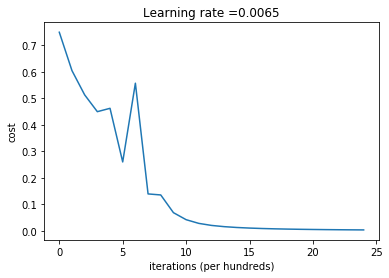

test accuracy: 78.0 %


In [16]:
tic = time.perf_counter()
costs = []
for i in range(2500):
    layer1.forward(train_x)
    activation1.forward(layer1.output)
    layer2.forward(activation1.output)
    activation2.forward(layer2.output)
    layer3.forward(activation2.output)
    activation3.forward(layer3.output)
    layer4.forward(activation3.output)
    sigmoid.forward(layer4.output)
    sigmoid.compute_cost(train_y)
    sigmoid.backward(train_y)
    layer4.backward(sigmoid.dZ)
    activation3.backward(layer4.dA)
    layer3.backward(activation3.dZ)
    activation2.backward(layer3.dA)
    layer2.backward(activation2.dZ)
    activation1.backward(layer2.dA)
    layer1.backward(activation1.dZ)
    
    if i % 100 == 0:
        costs.append(sigmoid.cost)
        predictions = predict(train_x)
        print('Iteration %d cost: %f' %(i, sigmoid.cost),"|",
             'Accuracy: {} %'.format(100 - cp.mean(cp.abs(predictions - train_y)) * 100))
        
toc = time.perf_counter()

print(f"Training time: {toc - tic:0.4f} seconds")
plt.plot(np.squeeze(costs))
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(layer1.lr))
plt.show()

predictions = predict(test_x)
print("test accuracy: {} %".format(100 - cp.mean(cp.abs(predictions - test_y)) * 100))

It looks like the GPU version trained in about half the time vs the CPU.  Not bad!

### Let's plot some pictures and see how the model did

In [39]:
def visualize_predictions(imgs, true_labels, predicted_labels, title):    
    plt.figure(1, figsize=(25,25))
    for i in range(5):
        plt.subplot(5,5, i+1)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
        plt.imshow(imgs[i])
        plt.title('True {} : Pred {}'.format(true_labels.T[i], predicted_labels.T[i]), fontsize=25)
        plt.suptitle(title, fontsize=35,x=0.5, y=.92)
        plt.xticks([]) , plt.yticks([])
    plt.show()

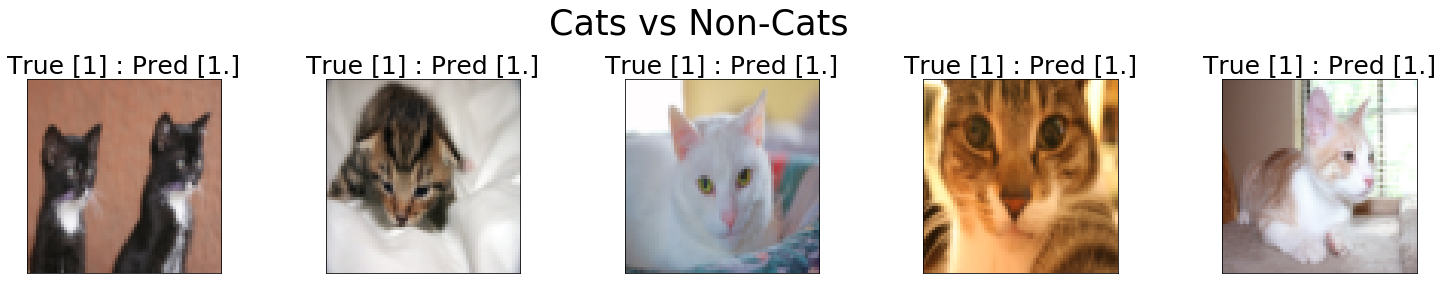

In [40]:
visualize_predictions(test_x_orig,test_y,predictions,'Cats vs Non-Cats')

![]('./cats.PNG')

![]('./cats.PNG')